# Import netflow sequence and box encoding

In [88]:
"""
# NOT NEEDED:

import csv

infile = "./data/flows_for_rnn_model_1000000.csv"
fp = open(infile, 'r')
flowdata = [[int(x) for x in line] for line in csv.reader(fp)]
fp.close()
"""

import bz2
import time

infile = "../sdata/flows_for_rnn_model_1000000.csv.bz2"

t0 = time.clock()
bz_file = bz2.BZ2File(infile)
lines = bz_file.readlines()
t1 = time.clock()

print "Time %g secs" % (t1-t0)
print(lines[:3])

Time 1.43216 secs
['1,0,2205,122,9501,138,1,27,28\n', '1,0,2244,122,8986,122,1,22,24\n', '1,0,2244,122,8986,122,1,22,24\n']


In [89]:
nlines = 1000
nlines = min(nlines, datasize)

flowdata = [[int(x) for x in line[:-1].split(',')] for line in lines[:nlines]]

In [75]:
flowdata[:10]

[[1, 0, 2205, 122, 9501, 138, 1, 27, 28],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 2408, 122, 8986, 122, 1, 20, 24],
 [1, 0, 2408, 122, 8986, 122, 1, 20, 24],
 [1, 0, 3022, 122, 9286, 122, 0, 12, 12],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5741, 122, 9492, 122, 1, 0, 0]]

Note that the schema is:

<ul>
<li> timestamp
<li> duration (scale-free-binned)
<li> source computer
<li> source port
<li> destination computer
<li> destination port
<li> protocol
<li> nr packets (scale-free-binned)
<li> nr bytes (scale-free-binned)
</ul>

In [76]:
# load box/port info from json:

import json
import re

boxdata = json.load(open("../sdata/boxport_data.json", 'r'))

def jsonIntKeys(x):
    if isinstance(x, dict):
            return {int(k):str(v) for k,v in x.items()}
    return x

def jsonIntVals(x):
    if isinstance(x, dict):
            return {str(k):int(v) for k,v in x.items()}
    return x

box_index = jsonIntVals( boxdata['box_indices'] )
index_box = jsonIntKeys( boxdata['indices_box'] )
port_index = jsonIntVals( boxdata['port_indices'] )
index_port = jsonIntKeys( boxdata['indices_port'] )

bbox = set([re.sub('[\"\n]+', "", s) for s in box_index.keys()])

In [77]:
# set RNN input vector sizes:

lg_duration = 24
lg_packets = 32
lg_bytes = 32
nr_proto = 4
nr_box = len(index_box)   # 10109
nr_port = len(index_port) #   326

# Import box embedding

In [78]:
# create dict from box name to 4-dimensional coords:

import csv 
infile = "../data/box_coords.csv"

fp = open(infile, 'r')
boxcoords = {line[0]: [float(line[i]) for i in range(1,5)] for line in csv.reader(fp)}
fp.close()

In [79]:
import numpy as np

comp_embed = np.zeros([nr_box, 4])

for b in boxcoords.keys():
    comp_embed[box_index[b],:] = boxcoords[b]

Visual inspection:

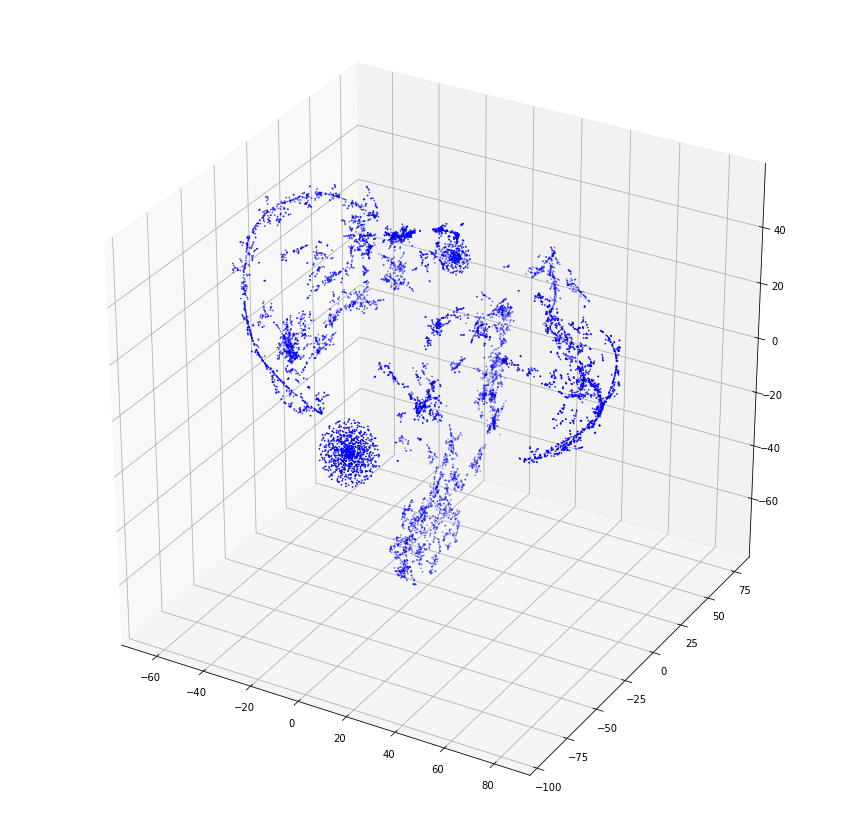

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = comp_embed[:,0]
y = comp_embed[:,1]
z = comp_embed[:,3]

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=0.5, c='b', edgecolor='face')
plt.show()

# RNN architecture

In [81]:
import sys
sys.setrecursionlimit(10000) # needed to prevent query-time bug...

from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model
from keras.layers.merge import Concatenate

# hyperparameters:
nhidden = [128, 128]
unroll = 32
embed_dim = 4
dropout_W = 0.1 # input gates
dropout_U = 0.1 # recurrent connections

# netflow inputs:
src_input = Input(shape=(unroll,), dtype='int32', name='src_input')
dst_input = Input(shape=(unroll,), dtype='int32', name='dst_input')
src_pt_input = Input(shape=(unroll,), dtype='int32', name='src_pt')
dst_pt_input = Input(shape=(unroll,), dtype='int32', name='dst_pt')
proto_input = Input(shape=(unroll,), dtype='int32', name='proto')
duration_input = Input(shape=(unroll,), dtype='int32', name='duration')
packets_input = Input(shape=(unroll,), dtype='int32', name='packets')
bytes_input = Input(shape=(unroll,), dtype='int32', name='bytes')

# shared embedding for computer feeds:
comp_encoding = Embedding(output_dim=embed_dim, input_dim=nr_box, input_length=unroll, weights=[comp_embed], trainable=False)
src = comp_encoding(src_input)
dst = comp_encoding(dst_input)

# other embeddings:
src_pt = Embedding(output_dim=128, input_dim=nr_port, input_length=unroll)(src_pt_input)
dst_pt = Embedding(output_dim=128, input_dim=nr_port, input_length=unroll)(dst_pt_input)
proto = Embedding(output_dim=2, input_dim=nr_proto, input_length=unroll)(proto_input)
duration = Embedding(output_dim=4, input_dim=lg_duration, input_length=unroll)(duration_input)
packets = Embedding(output_dim=8, input_dim=lg_packets, input_length=unroll)(packets_input)
bytes = Embedding(output_dim=16, input_dim=lg_bytes, input_length=unroll)(bytes_input)

# merge:
data_merged = Concatenate()([src_pt, dst_pt, proto, duration, packets, bytes])

# add src computer for next time-step, as a query stream to train on:
next_src = Input(shape=(unroll,), dtype='int32', name='next_src')
query = comp_encoding(next_src)

# pass data and query to RNN layers:
inner = Concatenate()([data_merged, src, dst, query])
for i in range(len(nhidden)-1):
    inner = LSTM(nhidden[i], return_sequences=True, dropout=dropout_U, recurrent_dropout=dropout_W)(inner)
inner = LSTM(nhidden[-1], return_sequences=False, dropout=dropout_U, recurrent_dropout=dropout_W)(inner)
inner = Dropout(dropout_W)(inner)

# add softmax outputs:
proto_output = Dense(4, activation='softmax', name='proto_output')(inner)
duration_output = Dense(lg_duration, activation='softmax', name='duration_output')(inner)
packets_output = Dense(lg_packets, activation='softmax', name='packets_output')(inner)
bytes_output = Dense(lg_bytes, activation='softmax', name='bytes_output')(inner)
src_port_output = Dense(nr_port, activation='softmax', name='src_port_output')(inner)
dst_port_output = Dense(nr_port, activation='softmax', name='dst_port_output')(inner)

# add dst computer output:
next_dst = Dense(embed_dim, activation='relu', name='next_dst')(inner)

# put it all together:
model = Model(inputs=[src_input,
                     dst_input,
                     src_pt_input,
                     dst_pt_input,
                     proto_input,
                     duration_input,
                     packets_input, 
                     bytes_input,
                     next_src], 
              outputs=[proto_output,
                      duration_output,
                      packets_output,
                      bytes_output,
                      src_port_output,
                      dst_port_output,
                      next_dst])

loss_weights = [0/0.5, # proto
                0/1.5,   # duration
                0/1.5,   # packets
                0/2.0,   # bytes
                0/1.0,   # src_port
                0/1.0,   # dst_prt
                1/500.0  # next_dst
               ]
model.compile(optimizer='rmsprop', 
              loss=['categorical_crossentropy' for i in range(6)] + ['mse'],
              loss_weights=loss_weights )

# ...and summarise:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
src_pt (InputLayer)              (None, 32)            0                                            
____________________________________________________________________________________________________
dst_pt (InputLayer)              (None, 32)            0                                            
____________________________________________________________________________________________________
proto (InputLayer)               (None, 32)            0                                            
____________________________________________________________________________________________________
duration (InputLayer)            (None, 32)            0                                            
___________________________________________________________________________________________

In [82]:
from keras.utils import plot_model

plot_model(model, to_file='../img/model.png')

# Prepare training/test data

In [84]:
import numpy as np

def make_input_vectors(z, mx, unroll=unroll):
    n = len(z)
    X = np.zeros((n - unroll, unroll), dtype='int32')
    for i in range(n - unroll):
        X[i,:] = z[i: i + unroll]
    return X

def make_onehot(x, n):
    N = len(x)-unroll
    out = np.zeros([N,n])
    for i in range(1,N):
        out[i, x[i]] = 1
    return out

def make_nextdst(x, cmp_code):
    N = len(x)-unroll
    out = np.zeros([N, embed_dim])
    for i in range(N):
        out[i,:] = cmp_code[x[i],:]
    return out

def make_train_seq(start, end):
    out = {}
    raw = np.array(flowdata[start:(end+1)])
    n = end - start
    out['input'] = [make_input_vectors(raw[range(n), 2], nr_box),
                    make_input_vectors(raw[range(n), 4], nr_box),
                    make_input_vectors(raw[range(n), 3], nr_port), 
                    make_input_vectors(raw[range(n), 5], nr_port),
                    make_input_vectors(raw[range(n), 6], nr_proto),
                    make_input_vectors(raw[range(n), 1], lg_duration),
                    make_input_vectors(raw[range(n), 7], lg_packets),
                    make_input_vectors(raw[range(n),8], lg_bytes),
                    make_input_vectors(raw[range(1,n+1),2], nr_box)]
    out['target'] = [make_onehot(raw[range(1,n+1), 6], nr_proto),
                     make_onehot(raw[range(1,n+1), 1], lg_duration),
                     make_onehot(raw[range(1,n+1), 7], lg_packets),
                     make_onehot(raw[range(1,n+1),8], lg_bytes),
                     make_onehot(raw[range(1,n+1), 3], nr_port),
                     make_onehot(raw[range(1,n+1), 5], nr_port),
                     make_nextdst(raw[range(1,n+1), 4], comp_embed)]
    out['raw'] = raw
    return out

In [87]:
datasize

1000000

In [90]:
N = 800

train = make_train_seq(0,N)
test = make_train_seq(N, nlines-1)

# Testing the architecture (optional)

In [91]:
tmp = [x[:100] for x in train['input']]
output = model.predict(tmp)
wts = model.get_weights()

print([y.shape for y in output])
print(output[0][1:10])

[(100, 4), (100, 24), (100, 32), (100, 32), (100, 326), (100, 326), (100, 4)]
[[ 0.20809653  0.31944537  0.25664926  0.21580887]
 [ 0.23139866  0.317963    0.23839076  0.21224755]
 [ 0.21687646  0.32205144  0.22220668  0.23886542]
 [ 0.2151266   0.32218879  0.2165401   0.24614446]
 [ 0.21136233  0.33359849  0.20874341  0.24629579]
 [ 0.22393493  0.36380184  0.20540322  0.20686005]
 [ 0.24227579  0.35884723  0.21088909  0.18798788]
 [ 0.24798785  0.36437249  0.20546767  0.18217202]
 [ 0.24358831  0.32846519  0.21154566  0.21640082]]


In [92]:
# of particular interest is the shared computer encoding, which will also be needed in the loss function:
wts = model.get_weights()
for w in wts: print(w.shape)

(326, 128)
(326, 128)
(4, 2)
(24, 4)
(32, 8)
(32, 16)
(10109, 4)
(298, 512)
(128, 512)
(512,)
(128, 512)
(128, 512)
(512,)
(128, 4)
(4,)
(128, 24)
(24,)
(128, 32)
(32,)
(128, 32)
(32,)
(128, 326)
(326,)
(128, 326)
(326,)
(128, 4)
(4,)


In [93]:
# check the computer embedding:

wts = model.get_weights()
print(wts[6][0])

print(comp_embed[0])

[  6.40943575  -0.33822641  49.54575729  39.56111526]
[  6.4094359   -0.33822642  49.54575826  39.56111665]


# Eyeball the training data (optional)

In [94]:
train['raw']

array([[   1,    0, 2205, ...,    1,   27,   28],
       [   1,    0, 2244, ...,    1,   22,   24],
       [   1,    0, 2244, ...,    1,   22,   24],
       ..., 
       [  45,    0, 9842, ...,    0,   12,   12],
       [  45,    0, 9928, ...,    1,   12,    9],
       [  45,   16, 5206, ...,    1,   20,   27]])

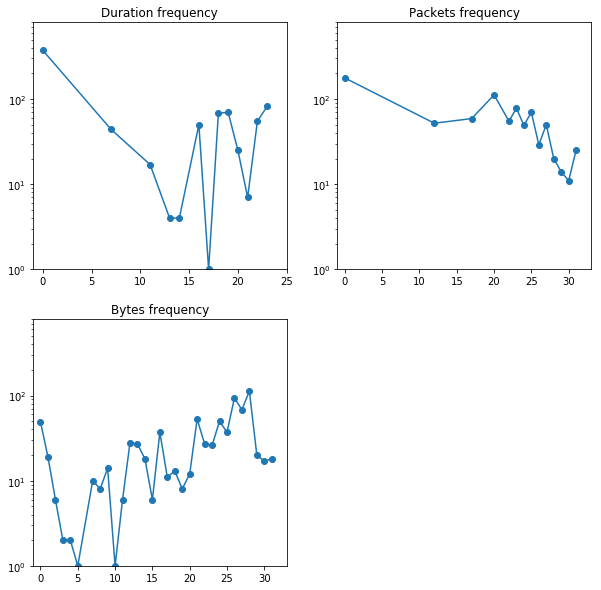

In [95]:
# histogram the duration, packets, bytes values:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2,2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2,2), (1, 0), colspan=1)

duration = list(train['raw'][:,1])
h = [[x, duration.count(x)] for x in set(duration)]
k = [x[0] for x in h]
v = [x[1] for x in h]
ax1.semilogy(k,v)
ax1.stem(k,v)
ax1.set_title("Duration frequency")
ax1.axis([-1, lg_duration+1, 1, N])

packets = list(train['raw'][:,7])
h = [[x, packets.count(x)] for x in set(packets)]
k = [x[0] for x in h]
v = [x[1] for x in h]
ax2.semilogy(k,v)
ax2.stem(k,v)
ax2.set_title("Packets frequency")
ax2.axis([-1, lg_packets+1, 1, N])

bytes = list(train['raw'][:,8])
h = [[x, bytes.count(x)] for x in set(bytes)]
k = [x[0] for x in h]
v = [x[1] for x in h]
ax3.semilogy(k,v)
ax3.stem(k,v)
ax3.set_title("Bytes frequency")
ax3.axis([-1, lg_bytes+1, 1, N])

plt.show()

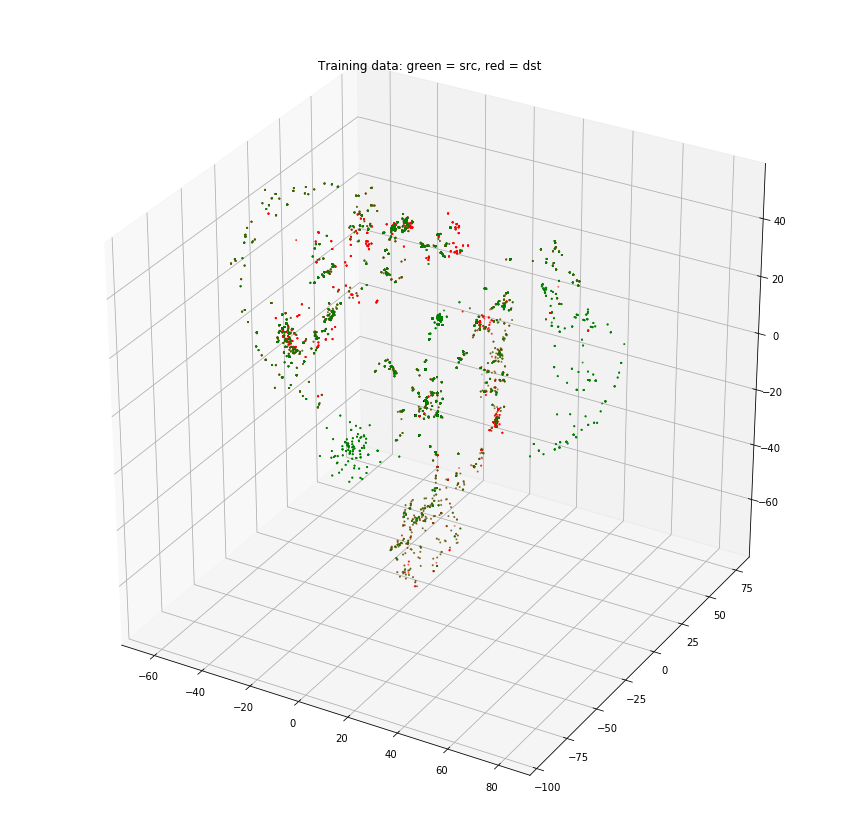

In [32]:
from mpl_toolkits.mplot3d import Axes3D

train_src = np.array([comp_embed[i,:] for i in train['raw'][:,2]])
train_dst = np.array([comp_embed[i,:] for i in train['raw'][:,4]])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

x = train_src[:,0]
y = train_src[:,1]
z = train_src[:,3]
ax.scatter(x,y,z, s=1, c='g', edgecolors='face')
x = train_dst[:,0]
y = train_dst[:,1]
z = train_dst[:,3]
ax.scatter(x,y,z, s=1, c='r', edgecolors='face')

plt.title("Training data: green = src, red = dst")
plt.show()

# Training the model

In [96]:
nr_epochs = 10

from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'total':[], 
                       'proto':[], 
                       'duration':[], 
                       'packets':[],
                       'bytes':[], 
                       'src_port':[], 
                       'dst_port':[], 
                       'next_dst':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['total'].append(logs.get('loss'))
        self.losses['proto'].append(logs.get('proto_output_loss'))
        self.losses['duration'].append(logs.get('duration_output_loss'))
        self.losses['packets'].append(logs.get('packets_output_loss'))
        self.losses['bytes'].append(logs.get('bytes_output_loss'))
        self.losses['src_port'].append(logs.get('src_port_output_loss'))
        self.losses['dst_port'].append(logs.get('dst_port_output_loss'))
        self.losses['next_dst'].append(logs.get('next_dst_loss'))

history = LossHistory()

model.fit(train['input'], train['target'], 
          epochs=nr_epochs, 
          verbose=1, 
          callbacks=[history])

Epoch 1/10
768/768 [==============================] - 9s - loss: 1.3257 - proto_output_loss: 1.4191 - duration_output_loss: 3.3140 - packets_output_loss: 3.8387 - bytes_output_loss: 3.6928 - src_port_output_loss: 5.9469 - dst_port_output_loss: 6.2631 - next_dst_loss: 662.8491      

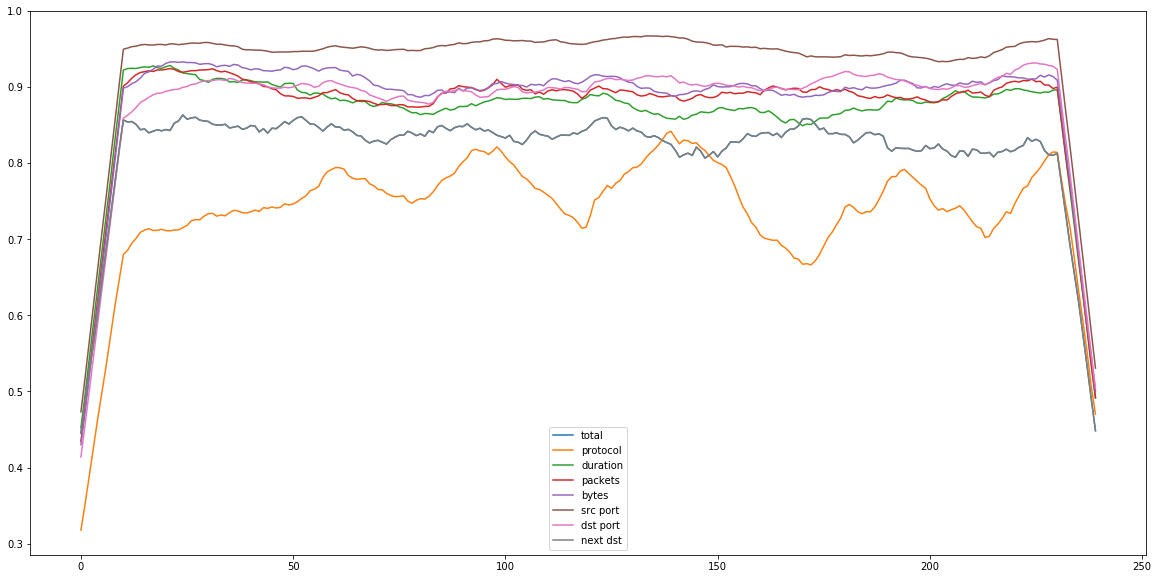

In [97]:
# show the SGD progress:

%matplotlib inline
import matplotlib.pyplot as plt

def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

total_loss = history.losses['total']/np.max(history.losses['total'])
proto_loss = history.losses['proto']/np.max(history.losses['proto'])
duration_loss = history.losses['duration']/np.max(history.losses['duration'])
packets_loss = history.losses['packets']/np.max(history.losses['packets'])
bytes_loss = history.losses['bytes']/np.max(history.losses['bytes'])
src_port_loss = history.losses['src_port']/np.max(history.losses['src_port'])
dst_port_loss = history.losses['dst_port']/np.max(history.losses['dst_port'])
next_dst_loss = history.losses['next_dst']/np.max(history.losses['next_dst'])

plt.figure(figsize=(20,10))
wsize = 20

plt.plot(movingaverage(total_loss, wsize), label='total')
plt.plot(movingaverage(proto_loss, wsize), label='protocol')
plt.plot(movingaverage(duration_loss, wsize), label='duration')
plt.plot(movingaverage(packets_loss, wsize), label='packets')
plt.plot(movingaverage(bytes_loss, wsize), label='bytes')
plt.plot(movingaverage(src_port_loss, wsize), label='src port')
plt.plot(movingaverage(dst_port_loss, wsize), label='dst port')
plt.plot(movingaverage(next_dst_loss, wsize), label='next dst')

plt.legend(loc='lower center')
plt.show()

Save the weights for later use:

In [98]:
fn = "model"
for i in nhidden: fn += "_%d" % i
fn += "_wts.npz"

np.savez("../models/%s" % fn, wts=wts)

# Load and test the model

In [99]:
np.load("../models/%s" % fn)
model.set_weights(wts)

In [100]:
test = make_train_seq(N+1, N+100)
predict = model.predict(test['input'])

proto_pred = predict[0]
duration_pred = predict[1]
packets_pred = predict[2]
bytes_pred = predict[3]
src_port_pred = predict[4]
dst_port_pred = predict[5]
next_dst_pred = predict[6]

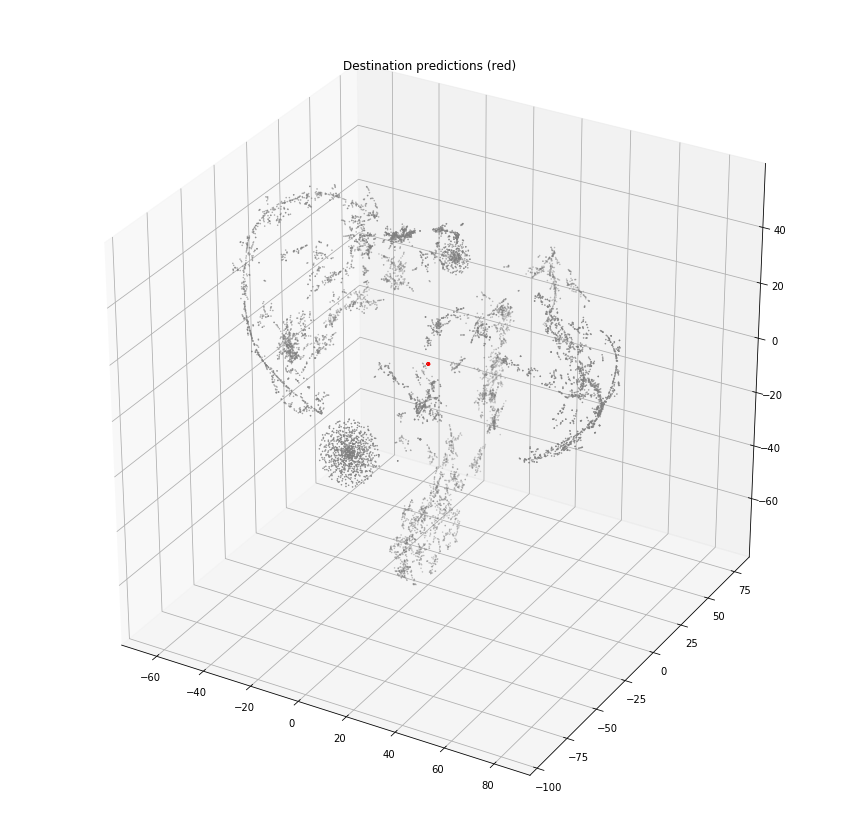

In [101]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

x = comp_embed[:,0]
y = comp_embed[:,1]
z = comp_embed[:,3]
ax.scatter(x,y,z, s=0.3, c='grey', edgecolors='face')
x = next_dst_pred[:,0]
y = next_dst_pred[:,1]
z = next_dst_pred[:,3]
ax.scatter(x,y,z, s=2, c='r', edgecolors='face')

plt.title("Destination predictions (red)")
plt.show()

MORE TESTS IN PROGRESS...